In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import matplotlib.patches as mpatches

Importing data, all the data is taken from the CBS https://www.cbs.gov.il/he/Statistics/Pages/%D7%9E%D7%97%D7%95%D7%9C%D7%9C%D7%99%D7%9D/%D7%9E%D7%97%D7%95%D7%9C%D7%9C-%D7%A1%D7%93%D7%A8%D7%95%D7%AA.aspxn

In [4]:
#Importing
df = pd.read_csv("dataset5_for_analysis.csv")
df2 = pd.read_csv("dataset5_for_analysis2.csv")
df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])

#Getting the data needed from df2 to df which will be our main df
df['unemp_f'] = (100 - df2['Emp_sea_f']).round(1)
df['unemp_m'] = (100 - df2['Emp_sea_m']).round(1)

print(df2['salary'])
print(df.dtypes)
print(df.head())

0      100.2
1       98.8
2      102.3
3       98.9
4       98.9
       ...  
156    126.9
157    130.0
158    138.9
159    130.2
160      NaN
Name: salary, Length: 161, dtype: float64
T          datetime64[ns]
M_emp             float64
M_self            float64
M_un              float64
F_emp             float64
F_self            float64
F_un              float64
salary            float64
unemp_f           float64
unemp_m           float64
dtype: object
           T  M_emp  M_self  M_un  F_emp  F_self  F_un  salary  unemp_f  \
0 2012-01-01   84.0    15.2   0.8   91.1     7.9   1.0   100.2     31.9   
1 2012-02-01   83.2    15.8   1.0   90.9     8.3   0.8    98.8     32.1   
2 2012-03-01   84.1    14.9   1.0   91.0     8.1   0.9   102.3     31.6   
3 2012-04-01   83.9    15.0   1.1   90.8     8.1   1.1    98.9     31.7   
4 2012-05-01   83.5    15.2   1.3   90.7     8.2   1.1    98.9     31.5   

   unemp_m  
0     21.0  
1     20.9  
2     20.6  
3     20.3  
4     20.4  


First, we'll examine the difference between self-employed men and women.

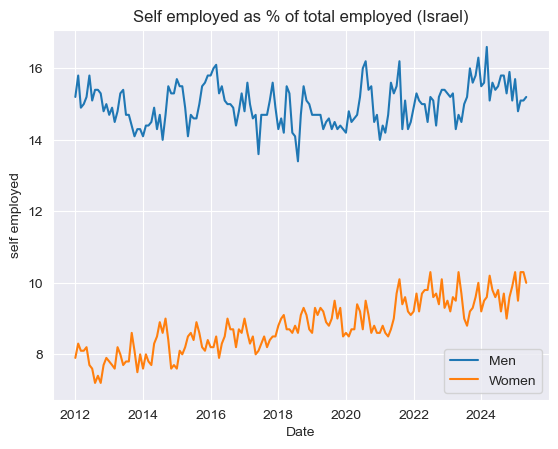

In [16]:
plt.plot(df['T'], df['M_self'], label='Men')
plt.plot(df['T'], df['F_self'], label='Women')
plt.legend()
plt.xlabel('Date')
plt.ylabel('self employed')
plt.title('Self employed as % of total employed (Israel)')
plt.show()

We can see a fairly consistent trend: women tend to become more self-employed over time. We won’t go into that more deeply, as it could be related to many factors — such as cultural ones — which would require data from a longer period and from other regions.

Next, we’ll try to remove the trend and seasonality effects.

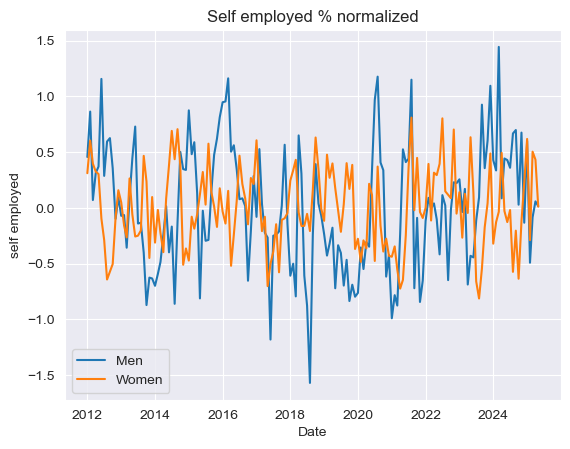

In [17]:
df_seas = df.copy()
df_seas['M'] = df_seas['T'].dt.month
df_seas['T_num'] = (df['T'] - df['T'].min()).dt.days


model_seasF = smf.ols('F_self ~ C(M) + T_num', data=df_seas).fit()
df_seas['F_seas'] = df_seas['F_self'] - model_seasF.fittedvalues

model_seasM = smf.ols('M_self ~ C(M) + T_num', data=df_seas).fit()
df_seas['M_seas'] = df_seas['M_self'] - model_seasM.fittedvalues


plt.title('Self employed % normalized')
plt.plot(df_seas['T'], df_seas['M_seas'], label='Men')
plt.plot(df_seas['T'], df_seas['F_seas'], label='Women')
plt.xlabel('Date')
plt.ylabel('self employed')
plt.legend()
plt.show()

And conduct some further analyses, all of them on our de-seasonalized and de-trended data.

In [18]:
print('Correlation between %self-employed women and men - ',df_seas['F_seas'].corr(df_seas['M_seas']),'\n')

print('sd of men self-employed - ', df_seas['M_seas'].std())
print('sd of women self-employed - ', df_seas['F_seas'].std(),'\n')

Correlation between %self-employed women and men -  0.021108722658040018 

sd of men self-employed -  0.5467745638939533
sd of women self-employed -  0.3556493684608574 



There is practically zero correlation between the men’s and women’s data, which is quite surprising given that it's the same index across different groups. This may suggest that different factors generally influence the decision to become (or stop being) self-employed for men and women.

Also, men appear to be much more volatile in that decision, with a standard deviation nearly twice as large.

Next, we’ll look at the relationship between self-employment and unemployment for each gender. To do that, we’ll de-trend the unemployment data (it is already de-seasonalized), and analyze it separately for the pre-COVID and post-COVID periods, since we’ll see that behavior changes over time.

In [19]:
model_seasF_un = smf.ols('unemp_f ~ T_num', data=df_seas).fit()
df_seas['F_seas_unemp'] = df_seas['unemp_f'] - model_seasF_un.fittedvalues

model_seasM_un = smf.ols('unemp_m ~ T_num', data=df_seas).fit()
df_seas['M_seas_unemp'] = df_seas['unemp_m'] - model_seasF_un.fittedvalues

df_pre = df_seas[df_seas['T'] < '2020-03-01'].copy()
df_crises = df_seas[df_seas['T'] >= '2020-03-01'].copy()

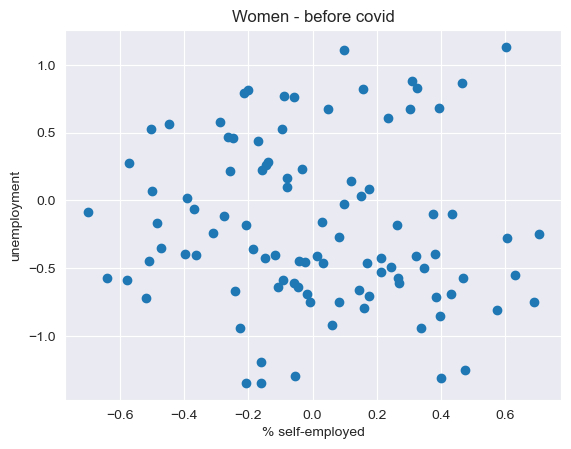

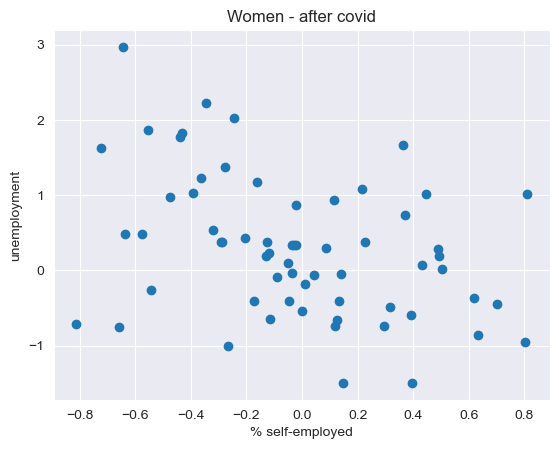

Correlation of self-employed women with unemployment before covid -  -0.08207859115893126
After covid -  -0.37874564609419814 

Correlation of self-employed men with unemployment before covid -  -0.3364620202710802
After covid -  0.01430019433464294


In [20]:
plt.scatter(df_pre['F_seas'], df_pre['F_seas_unemp'])
plt.xlabel('% self-employed')
plt.ylabel('unemployment')
plt.title('Women - before covid')
plt.show()

plt.scatter(df_crises['F_seas'], df_crises['F_seas_unemp'])
plt.xlabel('% self-employed')
plt.ylabel('unemployment')
plt.title('Women - after covid')
plt.show()

print('Correlation of self-employed women with unemployment before covid - ',df_pre['F_seas'].corr(df_pre['F_seas_unemp']))
print('After covid - ',df_crises['F_seas'].corr(df_crises['F_seas_unemp']), '\n')

print('Correlation of self-employed men with unemployment before covid - ',df_pre['M_seas'].corr(df_pre['M_seas_unemp']))
print('After covid - ',df_crises['M_seas'].corr(df_crises['M_seas_unemp']))

We can see that the relationship between self-employment and unemployment changed across both genders — but in different directions. While both men and women showed a negative correlation before COVID, after COVID the correlation became much more negative for women (−0.37), and essentially disappeared for men, with a correlation of just 0.01 between the variables.

This trend is also visible in the plots (women before COVID, and below it, women after COVID).

These results reinforce our hypothesis that different factors influence the decision to become self-employed for men and women — or at the very least, that they respond differently to the same factors.

Next, we will look at the relationship between unemployment and salary before, during, and after the COVID crisis, as well as the differences between men and women during the crisis.

In [21]:
date_covid = [pd.to_datetime('2020-04-01'), pd.to_datetime('2021-04-01')]

conditions = [
    df_seas['T'] < date_covid[0],
    (df_seas['T'] >= date_covid[0]) & (df_seas['T'] <= date_covid[1]),
    df_seas['T'] > date_covid[1]
]

choices = ['pre', 'crisis', 'post']
df_seas['status'] = np.select(conditions, choices)
color_map = {'pre': 'red', 'crisis': 'blue', 'post': 'green'}
colors = df_seas['status'].map(color_map)

legend_handles = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]


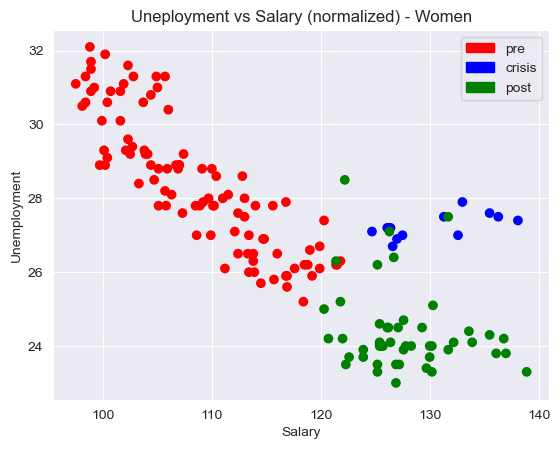

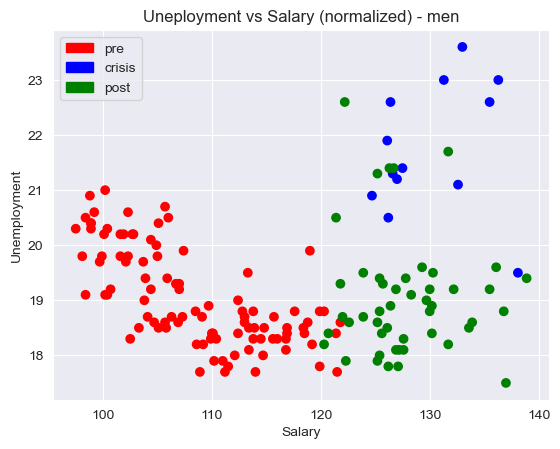

In [22]:
plt.scatter(df_seas['salary'], df_seas['unemp_f'], c = colors)
plt.xlabel('Salary')
plt.ylabel('Unemployment')
plt.title('Uneployment vs Salary (normalized) - Women')
plt.legend(handles = legend_handles )
plt.show()

plt.scatter(df_seas['salary'], df_seas['unemp_m'], c = colors)
plt.xlabel('Salary')
plt.ylabel('Unemployment')
plt.title('Uneployment vs Salary (normalized) - men')
plt.legend(handles = legend_handles )
plt.show()

We can see that for both men and women, the relationship between salary and unemployment shifted from negative to positive. This is likely due to low-wage workers being laid off — as shown in previous research (e.g.,  https://www.adpresearch.com/wp-content/uploads/2025/07/TaW_2025_Issue2-2025.pdf).

However, the shift was much more extreme for men. One possible explanation is that low-wage men are more likely to work in physical jobs than low-wage women, and those jobs were hit hardest during the COVID lockdowns. To test that hypothesis, we would need more detailed data and further analysis.

In conclusion men and women show different patterns in self-employment and how it relates to unemployment. Before COVID, both had a negative connection between self-employment and unemployment, but after COVID, this link became stronger for women and disappeared for men. Also, the relationship between salary and unemployment changed from negative to positive during the pandemic, with a bigger effect for men. This might be because men and women work in different kinds of jobs that were affected differently by lockdowns.